## Dependencies

In [89]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl

In [90]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')

def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

start = '2019-09-01 00:00:00'
end = '2020-08-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.03)


## Solving forward

In [91]:
## Contstraints and constants

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}}

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow
inflow_hydro1_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}
inflow_hydro2_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}

def inflow1_scenario(model, i, j):
    scenario_value = model.scenario.value
    if i == 'Hydro1':
        return model.inflow[i, j] == inflow_hydro1_scale[scenario_value] * inflow_hydro1[j]
    elif i == 'Hydro2':
        return model.inflow[i, j] == inflow_hydro2_scale[scenario_value] * inflow_hydro2[j]
# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['Buy',j] == model.L[j] - (model.r[j])

def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance

fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
    
def volume_change_rule(model, i, j):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) - (model.s[i,j]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j ] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) +(model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) -(model.s[i,j]*fm3)   

### Handling future cost

In [92]:
# Read water values and make them readable
fc = pd.read_csv('data/Future_cost.csv', index_col=0)
#display(fc)
#fc.plot()

# Define a function to convert string labels back to tuples
def label_parser(label):
    parts = label.strip('()').split(', ')
    return (int(parts[0]), int(parts[1]))

# Convert the MultiIndex labels to tuples for indexing
fc.index = fc.index.map(label_parser)
fc.columns = fc.columns.astype(int)
#map so that stage in stages call on the string name of the column in the dataframe when solving later
#column_mapping = {i: f'Stage {i}' for i in range(1, 51)}   #this is needed because the column names are not integers, but strings      
# Access a specific value using a tuple as the row label
value = fc.loc[(0, 0), 1]
stage1 = fc[1].to_dict()#.reset_index(drop=True)
#print(len(fc.index))

alpha = fc[1].to_dict()
print(alpha)
alpha_values = []

for key in fc.index:
    print("This is key:",key)
    alpha_values.append(alpha[key])

for i in range(len(fc.index)):
    print(alpha_values[i])

# ---------------------------- Water values -------------------------------------- #
wv1 = pd.read_csv('data/WV1.csv', index_col=0)
wv2 = pd.read_csv('data/WV2.csv', index_col=0)

wv1.index = wv1.index.map(label_parser)
wv2.index = wv2.index.map(label_parser)

wv1.columns = wv1.columns.astype(int)
wv2.columns = wv2.columns.astype(int)

value2 = wv1.loc[(0, 0), 1]
print(value2)

{(0, 0): 17889497.287243705, (0, 4): 17820149.547605168, (0, 8): 17589560.642093018, (0, 12): 17585316.692861136, (0, 16): 17485156.29076611, (0, 20): 17516035.831904847, (9, 0): 17579741.189177018, (9, 4): 17611841.81999566, (9, 8): 17623233.65135302, (9, 12): 17397154.855793018, (9, 16): 17304761.15621302, (9, 20): 17323232.51173702, (18, 0): 17265953.267093018, (18, 4): 17263024.1831743, (18, 8): 17068664.357093018, (18, 12): 17143374.18574102, (18, 16): 17044313.013713017, (18, 20): 16779347.536904726, (27, 0): 17005505.12459302, (27, 4): 16906860.66959302, (27, 8): 16808216.21459302, (27, 12): 16709571.759593025, (27, 16): 16610927.30459302, (27, 20): 16518899.394404726, (36, 0): 16745056.982093016, (36, 4): 16750414.85566634, (36, 8): 16547768.072093016, (36, 12): 16449123.617093015, (36, 16): 16350479.16209302, (36, 20): 16258878.130886195, (45, 0): 16593575.897433387, (45, 4): 16608493.534955677, (45, 8): 16396175.862892589, (45, 12): 16297531.407892589, (45, 16): 16198963.6635

In [93]:
def solve_first_stage(constants, topology, stage, alpha, Dual_values1, Dual_values2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24 + 1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart']) 
    print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    #print("This is volume", max(model.v))
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    #model.alpha_cons = pyo.Constraint(rule=create_alpha)
    model.alpha_cons = pyo.ConstraintList()   
    
    # List to store expected cost from next stage
    alpha_values = []
    Hydro1_volume = []
    Hydro2_volume = []
    lambda1_values = []
    lambda2_values = []

    #Appending values from next stage 
    for key in fc.index:
        lambda1_values.append(Dual_values1[key])
        lambda2_values.append(Dual_values2[key])
        alpha_values.append(alpha[key])        #Correct to assume that phi = alpha from next?
        Hydro1_volume.append(45)
        Hydro2_volume.append(20)
        #print("This is alpha:", alpha[key])


    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= alpha_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i])))
    
    #right now the alpha is always the top value from the matrix, which is wrong as it should be an arbitrary value restricted by the values in the matrix


    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_first, sense=pyo.minimize)
    return model


#model.probs 
#Solving functions:
def OBJ_first(model):
    return model.probs*(sum((model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) + model.alpha)  #should model.probs be included?

def OBJ_forward(model):
    return model.probs*(sum((model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) + model.alpha)


#def create_alpha(model):
#    return model.alpha >= model.phi + model.lambda1*(model.v['Hydro1',max(model.periods)] - model.v0['Hydro1']) + model.lambda2*(model.v['Hydro2',max(model.periods)] - model.v0['Hydro2'])

#in create alph,a lambda is multiplied with x_now - x_ref
#Alpha is the approximation of the future cost for week 2, which is limited by cuts (one cut for all of the 25 discretisation you calculated in the backward iteration).


def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True)             
    return results, model

def displayresults(model):
    print(model.dual.display())

In [94]:
def solve_forward(constants, topology, stage, start_vol, alpha, Dual_values1, Dual_values2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24+1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize={'Hydro1': start_vol[0], 'Hydro2': start_vol[1]}) 
    #print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, rule=volume_change_rule) 
    model.alpha_cons = pyo.ConstraintList()                              #Not really necessary since it's only adding one constraint that resets for every stage buy hey if it works it works
    
    # List to store expected cost from next stage
    alpha_values = []
    Hydro1_volume = []
    Hydro2_volume = []
    lambda1_values = []
    lambda2_values = []

    #Appending values from next stage 
    for key in fc.index:
        lambda1_values.append(Dual_values1[key])
        lambda2_values.append(Dual_values2[key])
        alpha_values.append(alpha[key])        #Correct to assume that phi = alpha from next?
        Hydro1_volume.append(start_vol[0])
        Hydro2_volume.append(start_vol[1])
        #print("This is alpha:", alpha[key])
    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= alpha_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i]))) #DO THIS
    
    #alpha and lambda values from matrix created for each state and stage in the backward iteration

    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_forward, sense=pyo.minimize)       #model.alpha is called here and should already be defined by the constraints or variable
        
    
    return model

In [95]:
## Solving forward loop for each stage after first stage
    # Solve individually for each stage and obtain the model.v values at the end of each stage
stages=range(1, 50 + 1, 1)
scenarios= ['High']#,'Avg', 'Low'] #
scenario_data = {}

Dual_values1={}
Dual_values2={}
alpha_values_list = []
#hydro1_water_val = []
#hydro2_water_val = []   
objective_values = []
constants['inflow_probabilities'] 
production_hydro1 = []
production_hydro2 = []
market = []


for s in scenarios:
    end_volume = {}
    print(' ')
    print('Solving for scenario', s)
    print(' ')
    alpha_values_scenario = []
    objective_values_scenario = []
    for stage in stages:
        if stage == 1:
            alpha = fc[stage+1].to_dict()        #Future cost in next stage, no future costs for stage 1 except one expected cost
            print(' ')
            print('Week: ', stage)
            Dual_values1 = wv1[stage].to_dict() #Dual_values1 
            Dual_values2 = wv2[stage].to_dict() #Dual_values2
            model = solve_first_stage(constants, topology, stage, alpha, Dual_values1, Dual_values2, s)  #,
            solve(model)
            expected = model.obj()
            objective_values.append(expected)
            objective_values_scenario.append(expected)

            stage_results = ()                                                                                   # Tuple to store volume results for each stage
            for i in model.plants:
                reservoir_v = model.v[i, max(model.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                    #this is the new initial volume for the next stage
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            print("This is the alpha value:",model.alpha.value)
            

            alpha_values_list.append(model.alpha.value)
            alpha_values_scenario.append(model.alpha.value)

            #Finding water values
            #Dual_values1[stage]= model.dual.get((model.volume_change_cons['Hydro1', max(model.periods)])) 
            #Dual_values2[stage]= model.dual.get((model.volume_change_cons['Hydro2', max(model.periods)])) 
            #hydro1_water_val.append(Dual_values1[stage])
            #hydro2_water_val.append(Dual_values2[stage])

        else:
            alpha = fc[stage+1].to_dict()
            print(' ')
            print('Week: ', stage)
            Dual_values1 = wv1[stage].to_dict() #Dual_values1 
            Dual_values2 = wv2[stage].to_dict() #Dual_values2

            model_forward = solve_forward(constants, topology, stage, start_vol, alpha, Dual_values1, Dual_values2, s) #  start_vol is the X_hat Dual_values1, Dual_values2,
            print("Start volume of stage ", stage, " is: ", model_forward.v0['Hydro1'], model_forward.v0['Hydro2'])
            solve(model_forward)
            expected = model_forward.obj() 
            objective_values.append(expected)
            objective_values_scenario.append(expected)

            stage_results = ()  
            for i in model_forward.plants:
                reservoir_v = model_forward.v[i, max(model_forward.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                         #this is the new initial volume for the next stage
            print("End volume of stage ", stage, " is: ", end_volume)
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            print("This is the alpha value:",model_forward.alpha.value)
            
            alpha_values_list.append(model_forward.alpha.value)
            alpha_values_scenario.append(model_forward.alpha.value)

            Dual_values1[stage]= model_forward.dual.get((model_forward.volume_change_cons['Hydro1', max(model_forward.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
            Dual_values2[stage]= model_forward.dual.get((model_forward.volume_change_cons['Hydro2', max(model_forward.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
            #hydro1_water_val.append(Dual_values1[stage])
            #hydro2_water_val.append(Dual_values2[stage])
    scenario_data[s] = {
        "alpha_values": alpha_values_scenario,
        "objective_values": objective_values_scenario,
    }


    print(Dual_values1)
    print(Dual_values2) 

 
Solving for scenario High
 
 
Week:  1
This is start volume: 45.0 20.0
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1212 rows, 2857 columns and 3632 nonzeros
Model fingerprint: 0x0a9d2e95
Coefficient statistics:
  Matrix range     [4e-03, 3e+04]
  Objective range  [3e-01, 2e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [1e-02, 2e+07]
Presolve removed 953 rows and 2084 columns
Presolve time: 0.01s
Presolved: 259 rows, 773 columns, 1030 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3016451e+06   4.998169e+00   0.000000e+00      0s
     329    6.3774097e+06   0.000000e+00   0.000000e+00      0s

Solved in 329 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.377409715e+06
This is the alpha v

In [96]:
##PROBLEM: Dual value in hte first two stages is 0, meaning that the water has no value and it is therefore quickly depleted. --> need to know what time range Oscar did simulation, and maybe what the initial dual value is?

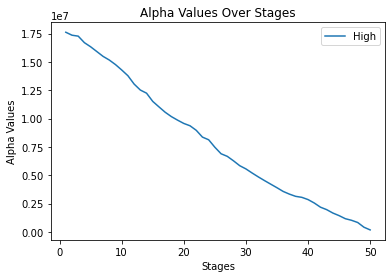

In [97]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in scenarios:
    alpha_values_scenario = scenario_data[s]["alpha_values"]
    x_values = range(1, len(alpha_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, alpha_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Alpha Values')
ax.set_title('Alpha Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()


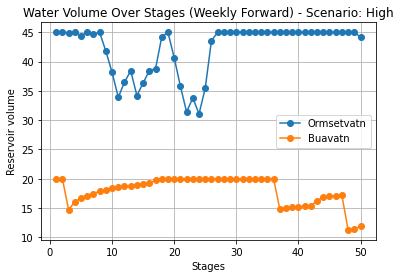

In [98]:
# Extract the keys (stages) and values from the dictionaries
stages = list(end_volume.keys())
values1 = [item[0] for item in end_volume.values()]
values2 = [item[1] for item in end_volume.values()]

plt.plot(stages, values1, label='Ormsetvatn', marker='o', linestyle='-')
plt.plot(stages, values2, label='Buavatn', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Stages')
plt.ylabel('Reservoir volume')
plt.title('Water Volume Over Stages (Weekly Forward) - Scenario: High')

# Add a legend to differentiate between Dual_values1 and Dual_values2
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

#Plot hourly!!!

In [99]:
print(scenario_data[s]["objective_values"])

[6377409.714712594, 6282014.679235325, 6201151.714757251, 6020746.369939301, 5968799.41623364, 5857425.927245207, 5678213.5541347675, 5644934.512376327, 5516321.5991035905, 5364619.253420435, 5205383.977135656, 5047137.949992795, 4896671.140426271, 4726938.113829048, 4564561.401528224, 4414592.008883187, 4146841.52967734, 4058132.88326408, 3968924.73098331, 3839191.1806024155, 3786701.3614539737, 3660686.636516011, 3524093.075138121, 3372755.424956062, 3219123.0683433153, 3028580.689188014, 2942009.614871787, 2761718.234434073, 2603070.986009304, 2467261.555663941, 2356222.9105234323, 2244991.1131884013, 2084170.241688845, 1908377.0829098993, 1835360.9795332598, 1741980.403281378, 1583338.5684774343, 1570511.4465677217, 1528037.3623903368, 1411516.2738109094, 1190324.7460688585, 1169751.4925772736, 1070071.0687012135, 940648.2359556105, 945397.0543661751, 853594.133643266, 799241.0297017088, 687115.6830653986, 607818.3977961466, 479419.00019269186]


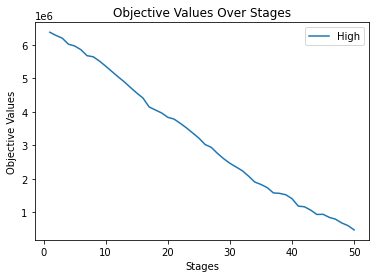

In [100]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in scenarios:
    objective_values_scenario = scenario_data[s]["objective_values"]
    x_values = range(1, len(objective_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, objective_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Objective Values')
ax.set_title('Objective Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()

In [17]:
!git push origin Main

fatal: Main cannot be resolved to branch


In [18]:
!git branch main_ben


In [19]:
!git checkout main_ben

SDP_Forward.ipynb: needs merge


error: you need to resolve your current index first


In [22]:
!git push origin main_ben

remote: 
remote: Create a pull request for 'main_ben' on GitHub by visiting:        
remote:      https://github.com/BenjaminTro/Preliminary-project/pull/new/main_ben        
remote: 
To https://github.com/BenjaminTro/Preliminary-project.git
 * [new branch]      main_ben -> main_ben


In [23]:
!git status


interactive rebase in progress; onto aae0f7f
Last command done (1 command done):
   pick 896717e ok
Next commands to do (5 remaining commands):
   pick a9b081c pol
   pick 4987620 Updated forward loop to run with FC over 1 year
  (use "git rebase --edit-todo" to view and edit)
You are currently rebasing branch 'main' on 'aae0f7f'.
  (fix conflicts and then run "git rebase --continue")
  (use "git rebase --skip" to skip this patch)
  (use "git rebase --abort" to check out the original branch)

Unmerged paths:
  (use "git restore --staged <file>..." to unstage)
  (use "git add <file>..." to mark resolution)
	both modified:   SDP_Forward.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [25]:
!git rebase --skip

Rebasing (2/6)
Rebasing (3/6)
Rebasing (4/6)
dropping 59e1e4a91e217c090faebdd0a27393503e7e1eea ok -- patch contents already upstream
Rebasing (5/6)
Rebasing (6/6)

Successfully rebased and updated refs/heads/main.


In [26]:
!git lfs track "data/raw/Normal_consumption.csv"


Tracking "data/raw/Normal_consumption.csv"


In [27]:
!git lfs install


Updated Git hooks.
Git LFS initialized.


In [28]:
!git add .

In [37]:
!git lfs track "data/raw/Normal_consumption.csv"

Tracking "data/raw/Normal_consumption.csv"


In [38]:
!git lfs ls-files

In [39]:
!git reset --hard HEAD~5

HEAD is now at aae0f7f Add files via upload


In [40]:
!git log

commit aae0f7f373c987dcaa5d01cae95f330fd3ffc16a
Author: BenjaminTro <97601230+BenjaminTro@users.noreply.github.com>
Date:   Mon Nov 20 11:08:15 2023 +0100

    Add files via upload

commit d8a9a4681bca0f4732eb1992c3cd5a69563740f1
Author: oscarsteen <oscarms@stud.ntnu.no>
Date:   Tue Nov 14 12:02:41 2023 +0100

    Marginal water values

commit 88600bef1bbfb2ca92de2412a892df6a6d848554
Author: BenjaminTro <97601230+BenjaminTro@users.noreply.github.com>
Date:   Wed Nov 8 21:27:31 2023 +0100

    SDP forward loop over one year for three scnearios
    
    (high: 1,5 avg: 1, low: 0.5) Normal_consumption.csv har fucka opp git'en igjen uten at jeg har pusha den >:(

commit 967e69315ab02b9c9596dd98c5a0dbf4a20fde71
Merge: 91c4893 f124ea3
Author: oscarsteen <oscarms@stud.ntnu.no>
Date:   Wed Nov 8 10:38:58 2023 +0100

    Merge branch 'main' of https://github.com/BenjaminTro/Preliminary-project

commit 91c4893cd77da9cbaaf9f6e3feb3ee465b85f5b2
Author: oscarsteen <oscarms@stud.ntnu.no>
Date:   Wed


commit c444017f40637be08f892ef287d4027c247400a2
Author: BenjaminTro <benjamjt@.ntnu.no>
Date:   Tue Sep 5 09:34:33 2023 +0200

    pushing datahandling.py

commit 7e1c679f4f5ddbf7a395efe33c2582377c27b6ab
Author: oscarsteen <oscarms@stud.ntnu.no>
Date:   Mon Sep 4 15:59:31 2023 +0200

    Kode for scheduling

commit 6b85ef664b3f713b70c561c68f938aa6b262f10c
Author: oscarsteen <oscarms@stud.ntnu.no>
Date:   Mon Sep 4 15:17:10 2023 +0200

    slette duplikatdata

commit 5424378669a2192e07cc4f32b6437050431edd77
Merge: e587e3d 96533fe
Author: BenjaminTro <benjamjt@.ntnu.no>
Date:   Mon Sep 4 13:52:49 2023 +0200

    Merge branch 'main' of https://github.com/BenjaminTro/Preliminary-project

commit e587e3dc33b65a304536768da9b468eb53875411
Merge: 403ff10 5841e4e
Author: BenjaminTro <benjamjt@.ntnu.no>
Date:   Mon Sep 4 13:50:01 2023 +0200

    Added data sent by Alex and merged them into complete .csv files (Market_price.csv and Data_inflow.csv)

commit 96533fedd6232c28066966236f9d4e90c49f0cb2